# **Health Insurance Cross Sell Prediction**

## **Import libraries and modules**

In [1]:
from modules.utils import Utils
from modules.categorical_analyses import CategoricalAnalyses
from modules.numerical_analyses import NumericalAnalyses
from modules.feature_engineering import FeatureEngineering
from modules.feature_selection import FeatureSelection
from modules.augmentation import Augmentation
from modules.modeling import Modeling

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

## **Collect data**

The test dataset doesn't have the target (`Response`) in it, so we can´t use it . <br><br>
We'll use the train dataset to split between train and test datasets!

In [2]:
# ToDo: Load DataFrame directly from GitHub Repo
# Load Train dataset
df_train_original = pd.read_csv('https://raw.githubusercontent.com/HugoTex98/Health-Insurance-Cross-Sell-Prediction/main/dataset/dataset.csv')
df_train_original

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [3]:
df_train_original["id"].value_counts()

id
381109    1
1         1
2         1
3         1
4         1
         ..
10        1
9         1
8         1
7         1
6         1
Name: count, Length: 381109, dtype: int64

There are **no repeated ID's** in the train dataset, which means that we can split into train and test without concernings about clients' overlap in both datasets. <br>
Let's use `stratify` from `train_test_split` to ensure equal percentage of our target (`Response`) in both training and test datasets. 

In [4]:
df_train, df_test = train_test_split(df_train_original, test_size=0.20, random_state=42, stratify=df_train_original["Response"])



Let's see how many examples there are in train dataset, and the number of our target `Response` classes:

In [5]:
print(f"No. of training examples: {df_train.shape[0]}")
print(f'Training set has: \n {df_train["Response"].value_counts()}')
print(f"Training set % of positive Response: {(len(df_train[df_train["Response"] == 1]) /
                                               df_train.shape[0]) *
                                               100}")

print(f"\nNo. of testing examples: {df_test.shape[0]}")
print(f'Test set has: \n {df_test["Response"].value_counts()}')
print(f"Test set % of positive Response: {(len(df_test[df_test["Response"] == 1]) /
                                           df_test.shape[0]) *
                                           100}")

No. of training examples: 304887
Training set has: 
 Response
0    267519
1     37368
Name: count, dtype: int64
Training set % of positive Response: 12.256344153735647

No. of testing examples: 76222
Test set has: 
 Response
0    66880
1     9342
Name: count, dtype: int64
Test set % of positive Response: 12.256303954238934


## **Data Understanding**

### General Exploration

Let's take a look at dataset's missing values and columns dtypes:

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304887 entries, 274710 to 221791
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   Gender                304887 non-null  object 
 2   Age                   304887 non-null  int64  
 3   Driving_License       304887 non-null  int64  
 4   Region_Code           304887 non-null  float64
 5   Previously_Insured    304887 non-null  int64  
 6   Vehicle_Age           304887 non-null  object 
 7   Vehicle_Damage        304887 non-null  object 
 8   Annual_Premium        304887 non-null  float64
 9   Policy_Sales_Channel  304887 non-null  float64
 10  Vintage               304887 non-null  int64  
 11  Response              304887 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 30.2+ MB


From the output above, it is possible to see that there are **no missing values** in the training dataset, having 3 different dtypes. <br><br>
We'll observe a statistical summary of the dataset numerical columns below:

In [7]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000
mean,190738.657112,38.826897,0.997855,26.396239,0.458127,30591.308311,112.053859,154.392214,0.122563
std,110004.367239,15.515299,0.046265,13.228749,0.498244,17239.285689,54.189288,83.670312,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95504.500000,25.000000,1.000000,15.000000,0.000000,24403.000000,29.000000,82.000000,0.000000
50%,190886.000000,36.000000,1.000000,28.000000,0.000000,31697.000000,134.000000,154.000000,0.000000
75%,285863.500000,49.000000,1.000000,35.000000,1.000000,39443.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [8]:
# store numerical columns
num_cols = df_train.select_dtypes(include=['int', 'float']).columns.tolist()

The columns `Driving_License` and `Previously_Insured` are binary, indicating whether a client has driving license or if was previously insured in a past accident, respectively. <br><br>
Let's take a look at the categorical columns:

In [9]:
# store categorical columns
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
cat_cols

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [10]:
df_train[cat_cols].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164780,160195,153959


In [11]:
print("Gender classes: ", df_train['Gender'].unique())
print("Vehicle Age classes: ", df_train['Vehicle_Age'].unique())
print("Vehicle Damage classes: ", df_train['Vehicle_Damage'].unique())

Gender classes:  ['Male' 'Female']
Vehicle Age classes:  ['< 1 Year' '1-2 Year' '> 2 Years']
Vehicle Damage classes:  ['Yes' 'No']


### Numerical Features Analysis

In [12]:
# instatiate NumericalAnalyses class for these analysis
num_analysis = NumericalAnalyses(df_train[num_cols])

In [14]:
num_cols

['id',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

Since `Driving_License`, `Previously_Insured`, and `Response` (our target) are binary variables, we'll observe their distributions jointly with the Categorical features. <br><br>
The `id ` column is not used for any of these explorations. 

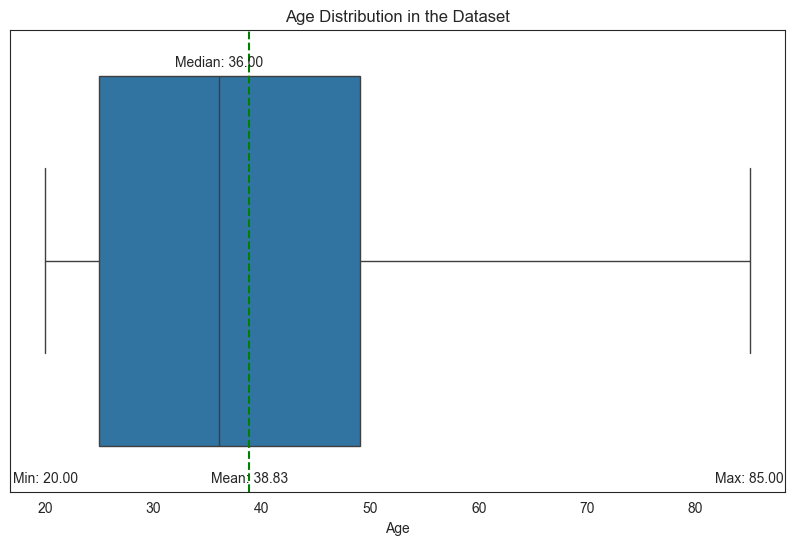

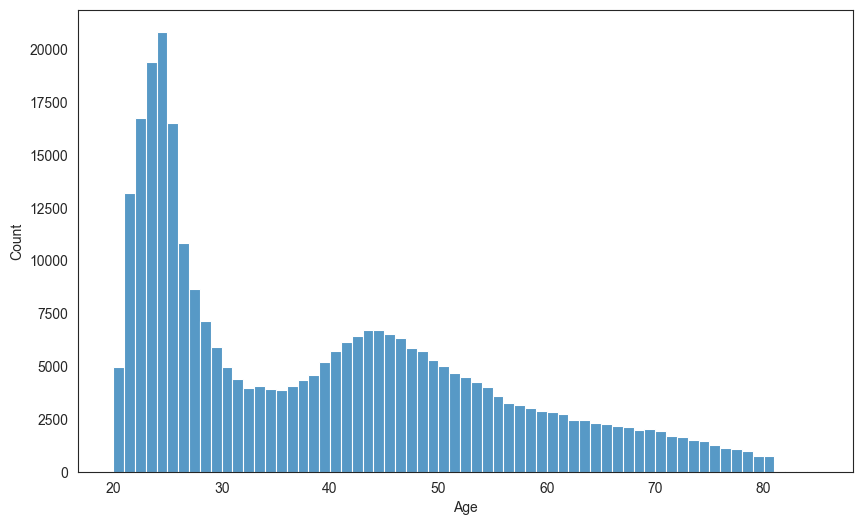

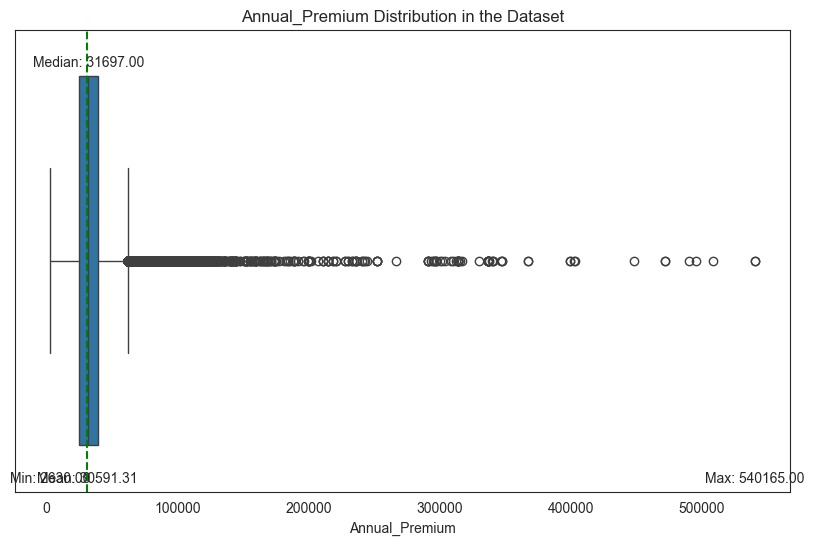

KeyboardInterrupt: 

: 

: 

In [77]:
for col in ['Age', 'Annual_Premium', 'Vintage']:
    num_analysis.boxplots(col)
    num_analysis.hist(col)

From the box plot's above, we can see that the variables `Age` and `Vintage` have distributions relatively symmetrical, with the `Age` varible having a slight right (positive) skewness (mean greater than median), indicating more client with higher ages. <br><br>
On the other hand, the `Annual_Premium` has higher number of outliers, reflecting the discrepancy in the premiums applied by each client. It needs to be further analyzed to process these outliers.    

The `Region_Code` and `Policy_Sales_Channel` will be explored through bar plots:

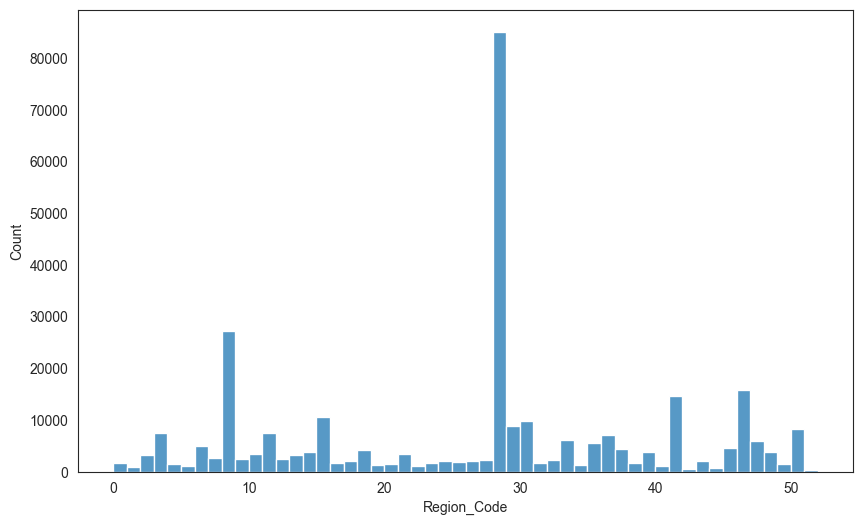

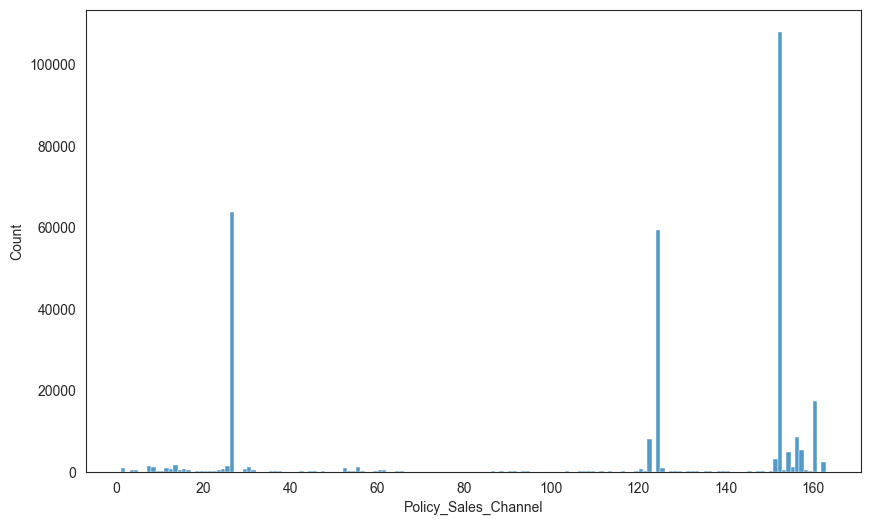

In [16]:
for col in ['Region_Code', 'Policy_Sales_Channel']:
    num_analysis.hist(col)

### Categorical Features Analysis

In [17]:
cat_analysis = CategoricalAnalyses(df_train)

In [18]:
cat_cols

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

Let's explore the distributions of the Categorical features above, along with the features that are not as `object` type in the DataFrame but are binary: `Driving_License`, `Previously_Insured`.

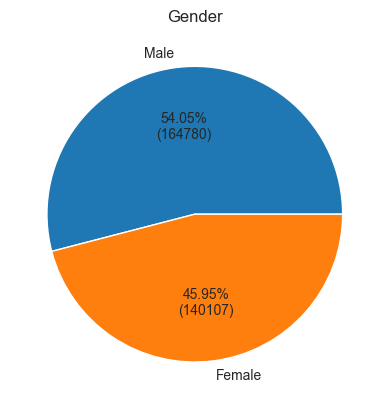

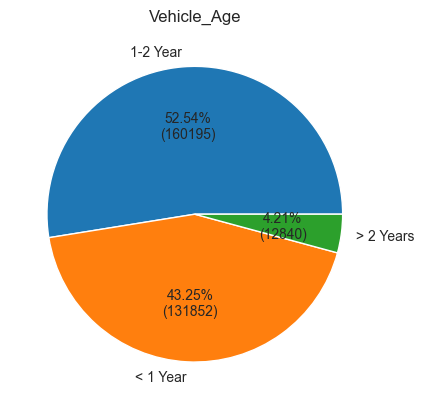

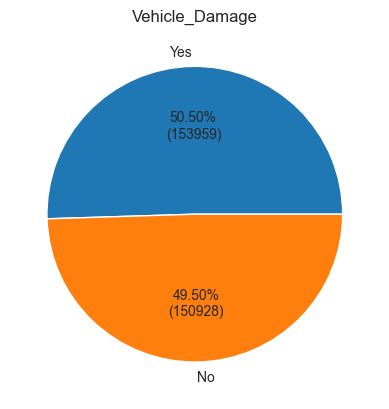

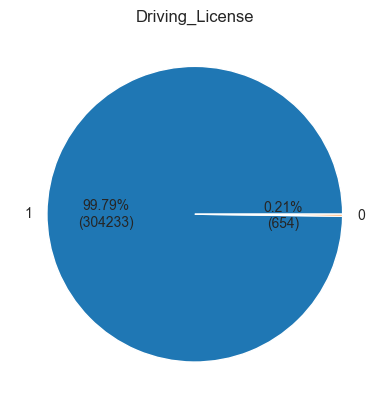

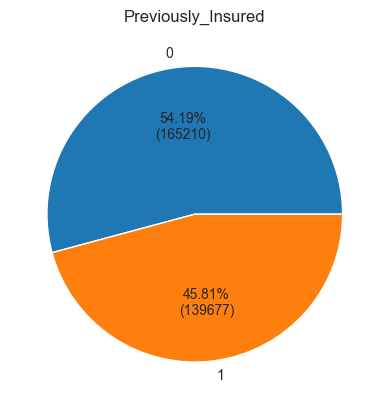

In [19]:
cat_analysis.pie(cat_cols + ["Driving_License", "Previously_Insured"])

From the pie charts above, can conclude:

- There are slightly more Males than Females;
- Approximately 96% of the health insured clients have a **car with or less than 2 years**;
- There's an equal proportion of clients who have suffered an accident and those who have not;
- Only 0.21% of the clients **do not possess driving license**;
- There are slightly more clients that have been previously insured than those who have never been.

## **Data Exploration**

Let's explore how some dataset variables might relate with each other, allowing us to have a better understanding of our clients profile. 

### **Categorical Variables**

#### Response vs Gender

Starting to understand how the `Gender` can be important in acquiring an Vehicle Insurance (when our target `Response` is 1).  

In [62]:
# Group the data by Gender and Response and count the occurrences
gender_resp = df_train.groupby(['Gender', 
                                'Response'])['id'] \
                                    .count().to_frame() \
                                        .rename(columns={'id': 'count'}) \
                                            .reset_index()

gender_resp["Response"] = gender_resp["Response"].replace({0:"No", 1:"Yes"}) 
gender_resp

,Gender,Response,count
0,Female,No,125490
1,Female,Yes,14617
2,Male,No,142029
3,Male,Yes,22751


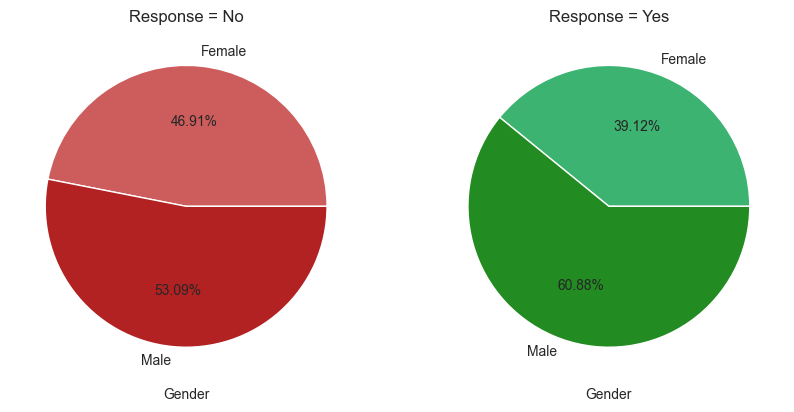

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Loop over the Response categories and plot the data for each Gender category
for i, response in enumerate(gender_resp['Response'].unique()):
    data = gender_resp[gender_resp['Response'] == response]
    ax = axs[i]
    color = ["indianred","firebrick"] if response == "No" else ["mediumseagreen", "forestgreen"]
    ax.pie(data['count'], labels=data['Gender'], colors=color, autopct='%1.2f%%')
    ax.set_title(f"Response = {response}")
    ax.set_xlabel('Gender')

plt.show()

In the `Response = 1` is evidently that Male clients are more interested in acquiring an Vehicle Insurance. This might be due to several reasons, for example, usually Male drivers are more prone to accidents because they have a more agressive driving. 
<br>
It is important to mention, from the initial distribution analysis on `Gender`, that we have around 8% more Males (164780) than Females (140107).
<br><br>
Let's explore that. 

#### Vehicle Damage and Responses

In [15]:
gender_damage = df_train[df_train["Response"] == 1].groupby(['Gender',
                                                              'Vehicle_Damage'])['id'] \
                                                                .count().to_frame() \
                                                                    .rename(columns={'id': 'count'}) \
                                                                        .reset_index()

gender_damage

,Gender,Vehicle_Damage,count
0,Female,No,331
1,Female,Yes,14286
2,Male,No,463
3,Male,Yes,22288


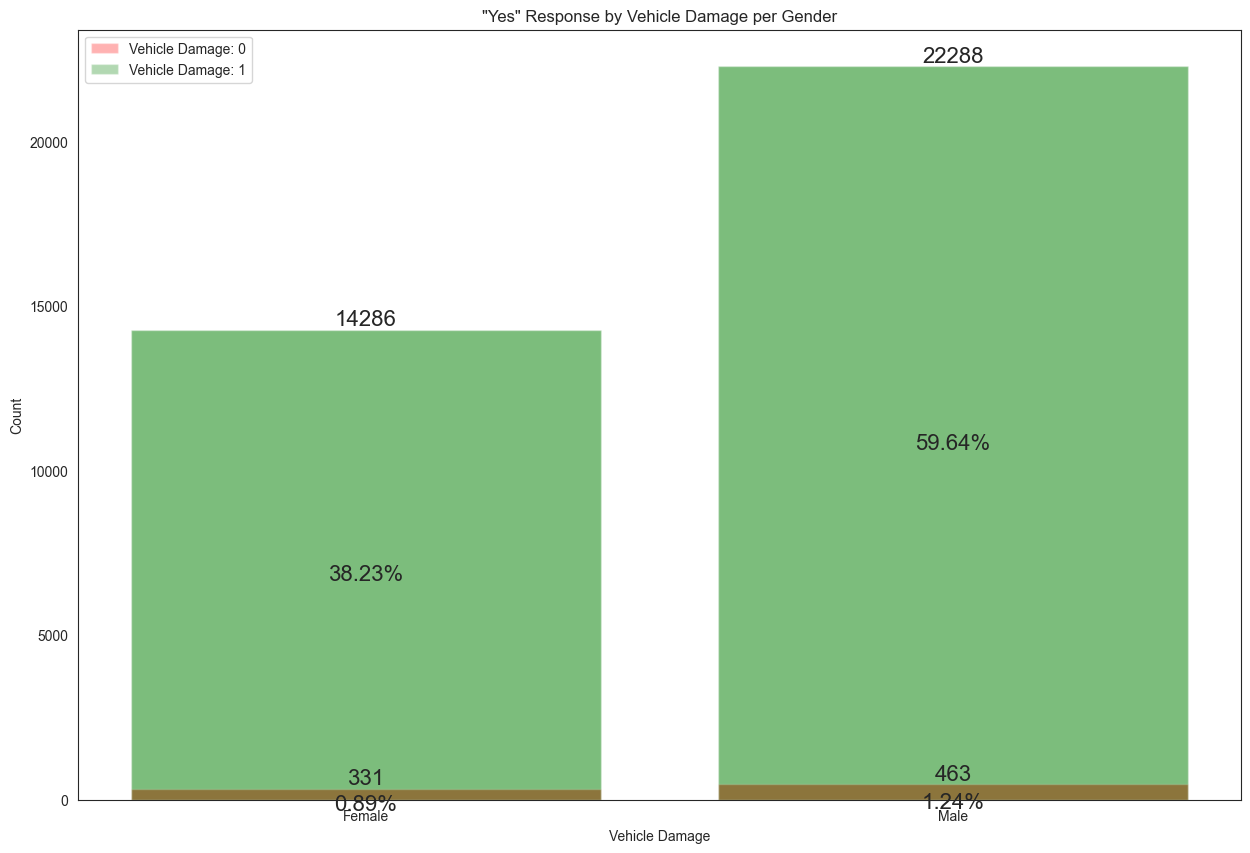

In [18]:
plt.figure(figsize=(15,10))
plt.bar(gender_damage['Gender'], 
        gender_damage['count'], color=['red', 
                                       'green'], 
                                       alpha=0.3)
plt.xlabel('Vehicle Damage')
plt.ylabel('Count')
plt.title('"Yes" Response by Vehicle Damage per Gender')
bars = plt.bar(gender_damage['Gender'], 
               gender_damage['count'], color=['red', 
                                              'green'], 
                                              alpha=0.3)

# Add count and percentage labels inside the bars
for bar in bars:
    height = bar.get_height()
    percentage = '{:.2f}%'.format((height / gender_damage['count'].sum()) * 100)
    count_label = str(int(height))
    plt.text(bar.get_x() + bar.get_width() / 2, height, count_label, ha='center', va='bottom', fontsize=16)
    plt.text(bar.get_x() + bar.get_width() / 2, height/2, percentage, ha='center', va='top',  fontsize=16)

plt.legend(bars, ['Vehicle Damage: 0', 'Vehicle Damage: 1'])
plt.show()

From the above bar plot it is possible to conclude than, no matter the `Gender`, having a **car accident in the past** is important for these clients to acquire Vehicle Insurance!

#### Previously Insured vs Response

If a client already has a Vehicle Insurance, one of two things can happen: 

1. The client is fully satisfied with it's insurance, and don't have any plans for a change;
2. The client is not satisfied with it's insurance, in many ways, and plans to change for a better one.

Let's find out how this is affecting our target `Response`!

In [21]:
# Group the data by Gender and Response and count the occurrences
resp_previnsured = df_train_original.groupby(['Previously_Insured', 
                                              'Response'])['id'].count() \
                                                .to_frame().rename(columns={'id': 'count'}) \
                                                    .reset_index()
resp_previnsured

,Previously_Insured,Response,count
0,0,0,159929
1,0,1,46552
2,1,0,174470
3,1,1,158


In [59]:
resp_previnsured['Previously_Insured'] = resp_previnsured['Previously_Insured'].replace({0:'No',1:'Yes'})
resp_previnsured['Response'] = resp_previnsured['Response'].replace({0:'No',1:'Yes'})
resp_previnsured

,Previously_Insured,Response,count
0,No,No,159929
1,No,Yes,46552
2,Yes,No,174470
3,Yes,Yes,158


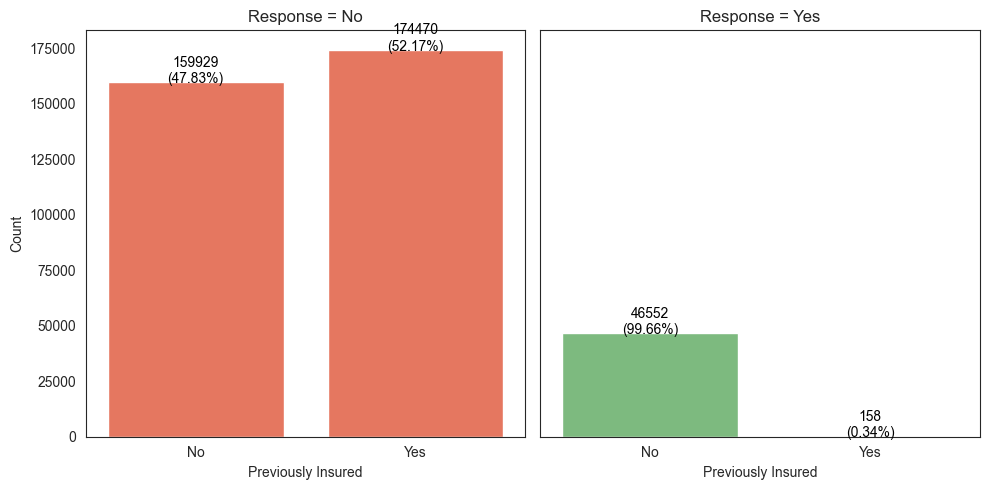

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)

# Loop over the Response categories and plot the data for each Response category
for i, response in enumerate(resp_previnsured['Response'].unique()):
    data = resp_previnsured[resp_previnsured['Response'] == response]
    total_count = data['count'].sum()
    
    sns.barplot(x='Previously_Insured', y='count', data=data, hue='Response', 
                palette='Reds' if response == 'No' else 'Greens', ax=axs[i], legend=False)
    
    # Annotate each bar with count and percentage
    for p in axs[i].patches:
        count = p.get_height()  # Get the height of the bar (count value)
        percentage = count / total_count * 100  # Calculate percentage
        # Annotate with count and percentage
        axs[i].annotate(f'{int(count)}\n({percentage:.2f}%)', 
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # Coordinates for the text
                        ha='center', va='center', fontsize=10, color='black', 
                        xytext=(0, 8), textcoords='offset points')  # Offset the text slightly above the bar

    
    axs[i].set_title(f'Response = {response}')
    axs[i].set_xlabel('Previously Insured')

axs[0].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [40]:
resp_previnsured[(resp_previnsured["Previously_Insured"] == 'No') & \
                 (resp_previnsured["Response"] == 1)]["count"] \
                / (resp_previnsured[resp_previnsured["Previously_Insured"] == 'No']["count"].sum()) * 100

1    22.545416
Name: count, dtype: float64

From the bar chart above we can conclude that out of the customers who do not have Vehicle Insurance, **99.66% of them would buy the Vehicle Insurance** offered by the Health Insurance Company. However, when we consider the full sample, **the company is attracting only 22.54% of customers who do not have Auto Insurance.** 
<br><br>

In terms of customers switching from their Vehicle Insurance to the Health Insurance company's Vehicle Insurance, only a tiny portion of customers would switch from their Vehicle Insurance. **Health Insurance company's Vehicle Insurance may not be more attractive and with more benefits compared to others.**

#### Vehicle Age vs Response

It's pretty clear to think that if a person has a brand new car, automatically thinks of acquiring a Vehicle Insurance, to be more safe and relaxed in case of something happens. <br><br>
Let's see if we see that pattern here.

In [13]:
vehicle_age_resp = df_train.groupby(["Vehicle_Age", "Response"])["id"] \
                                    .count() \
                                        .to_frame() \
                                            .rename(columns={'id':'count'}) \
                                                .reset_index()

vehicle_age_resp["Response"] = vehicle_age_resp["Response"].replace({0:'No', 1:'Yes'})
# Order Vehicle_Age indexes to have the correct order in the plot
vehicle_age_resp = vehicle_age_resp.reindex([2,3,0,1,4,5])
vehicle_age_resp

,Vehicle_Age,Response,count
2,< 1 Year,No,126063
3,< 1 Year,Yes,5789
0,1-2 Year,No,132376
1,1-2 Year,Yes,27819
4,> 2 Years,No,9080
5,> 2 Years,Yes,3760


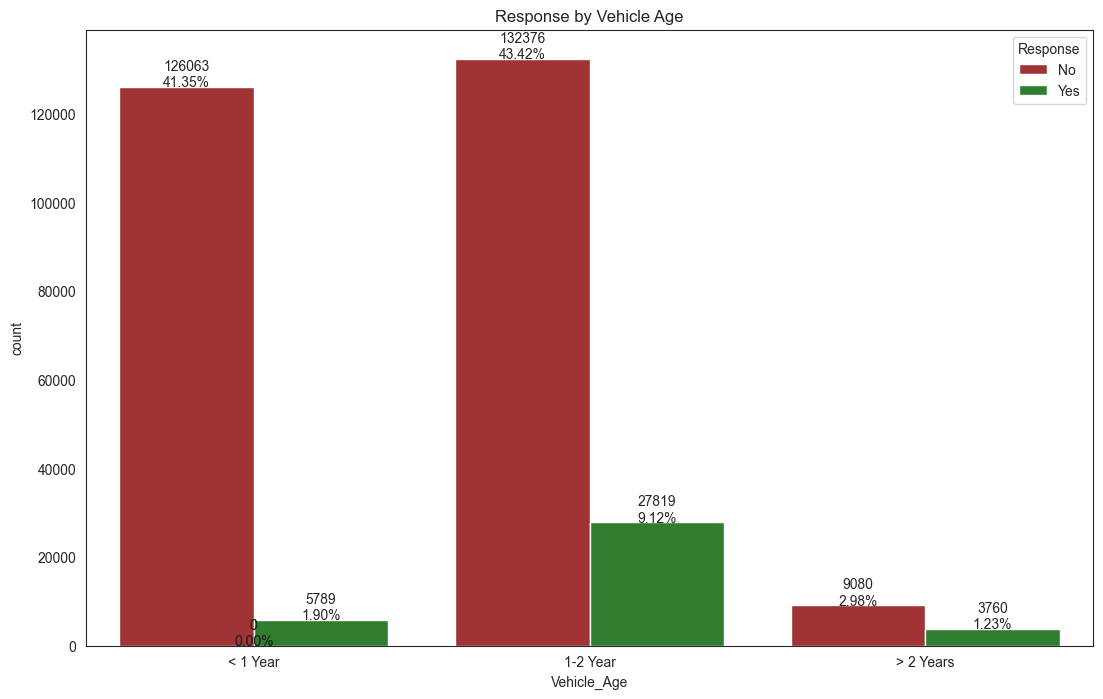

In [14]:
plt.figure(figsize=(13,8))
ax = sns.barplot(x='Vehicle_Age', y='count', hue='Response', data=vehicle_age_resp, 
                 palette=['firebrick','forestgreen']) # ["indianred","firebrick"] ["mediumseagreen", "forestgreen"]

# Calculate count and percentage for each bar
total_counts = vehicle_age_resp['count'].sum()
for p in ax.patches:
    height = p.get_height() # Get the height of the bar (count value)
    count = int(height)
    percentage = (count / total_counts) * 100
    ax.annotate(f'{count}\n{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), # Coordinates for the text
                ha='center', va='center', xytext=(0, 9), textcoords='offset points') # Offset the text slightly above the bar

plt.title("Response by Vehicle Age")
plt.show()

### **Numerical Variables**

#### Age vs Response

It is also important to understand if the `Age` can be a factor when it comes to acquire a Vehicle Insurance.

In [5]:
age_resp = df_train.groupby(['Age', 
                            'Response'])['id'].count().to_frame() \
                                .rename(columns={'id': 'count'}) \
                                    .reset_index()
age_resp


,Age,Response,count
0,20,0,4817
1,20,1,134
2,21,0,12731
3,21,1,460
4,22,0,16143
...,...,...,...
125,82,1,1
126,83,0,14
127,83,1,1
128,84,0,10


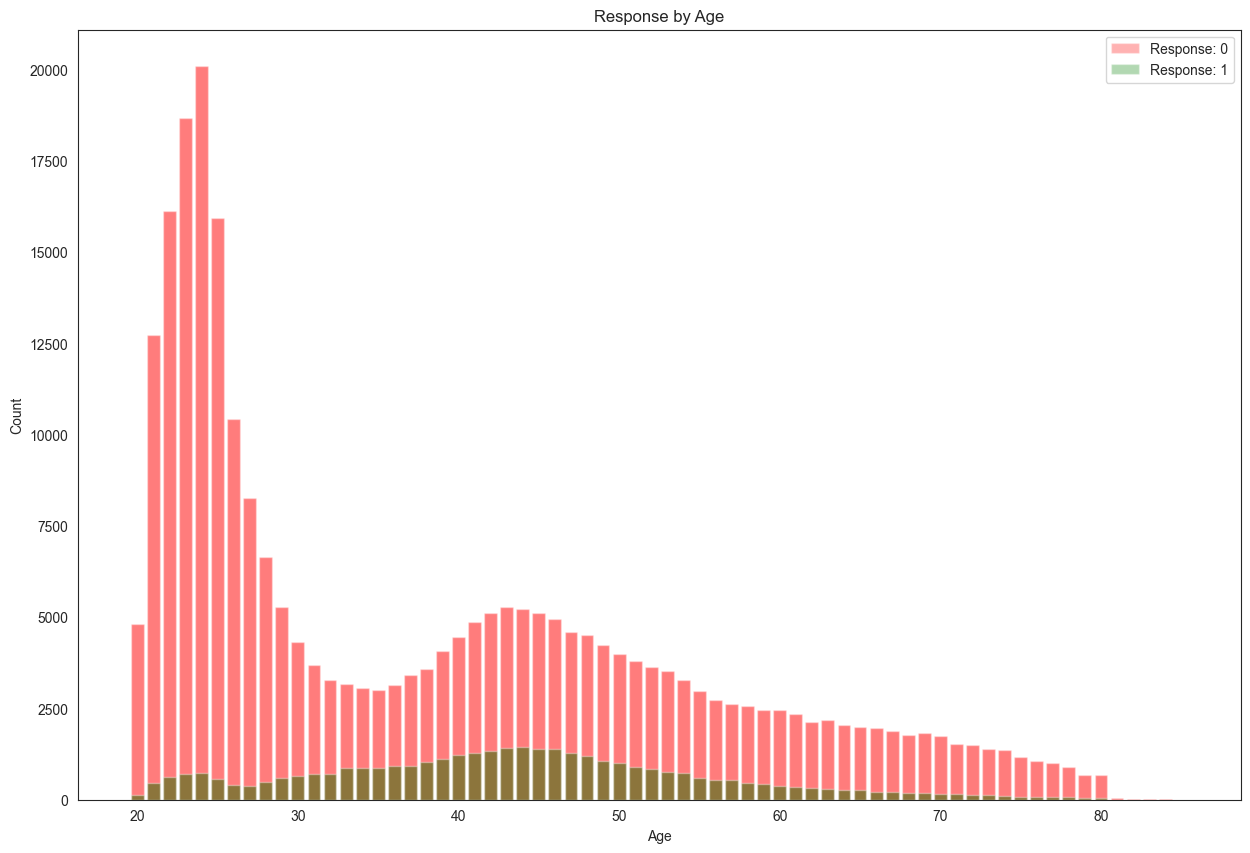

In [6]:
plt.figure(figsize=(15,10))
plt.bar(age_resp['Age'], age_resp['count'], color=['red', 'green'], alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Response by Age')
bars = plt.bar(age_resp['Age'], age_resp['count'], color=['red', 'green'], alpha=0.3)

plt.legend(bars, ['Response: 0', 'Response: 1'])
plt.show()

In terms of total of observations, it's clear that the 'No' `Response` is predominant. 
<br><br>
Let's explore this relationship but with another statistic like **probability**. **Probability** focuses on relative frequencies instead of raw counts.

In [66]:
response_age = df_train[['Age', 'Response']]
response_1 = response_age[response_age['Response'] == 1]
response_0 = response_age[response_age['Response'] == 0]

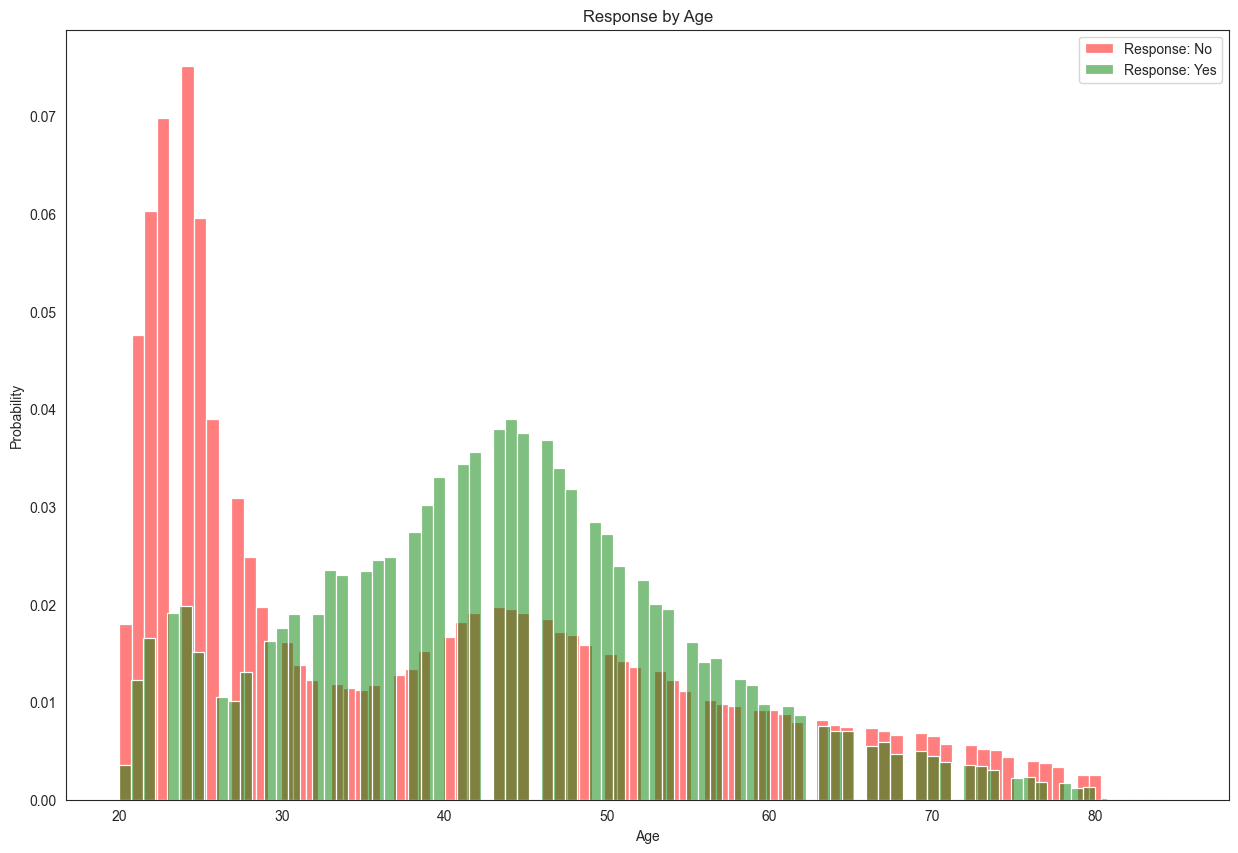

In [67]:
fig, ax = plt.subplots(figsize=(15, 10))
# Plot the histogram for Response 0
sns.histplot(response_0['Age'], ax=ax, stat='probability', color='red', # color='#EFB792', 
             alpha=0.5, element='bars', fill=True, 
             bins=int(response_age['Age'].max()))
# Plot the histogram for Response 1
sns.histplot(response_1['Age'], ax=ax, stat='probability', color='green', # color='#8DE5A1', 
             alpha=0.5, element='bars', fill=True, 
             bins=int(response_age['Age'].max()))

ax.set_xlabel('Age')
ax.set_ylabel('Probability')
ax.set_title('Response by Age')
ax.legend(labels=['Response: No', 'Response: Yes'])
plt.show()

When explored the **probability** of the `Response` of the clients by their `Age`, it's possible to observe that there's a higher probability that clients within 31-58 years of Age, are interested in acquiring a Vehicle Insurance. <br>
This might occur due to their finantial stability, which oposes to the clients below 30 years old, and the fact that above 60 years old, people start to drive less (because of visual problems, health concerns, etc).

#### Vintage vs Response

We can now explore whether a Health Insurance customer's seniority may have an impact on acquiring a Vehicle Insurance provided by this company. 

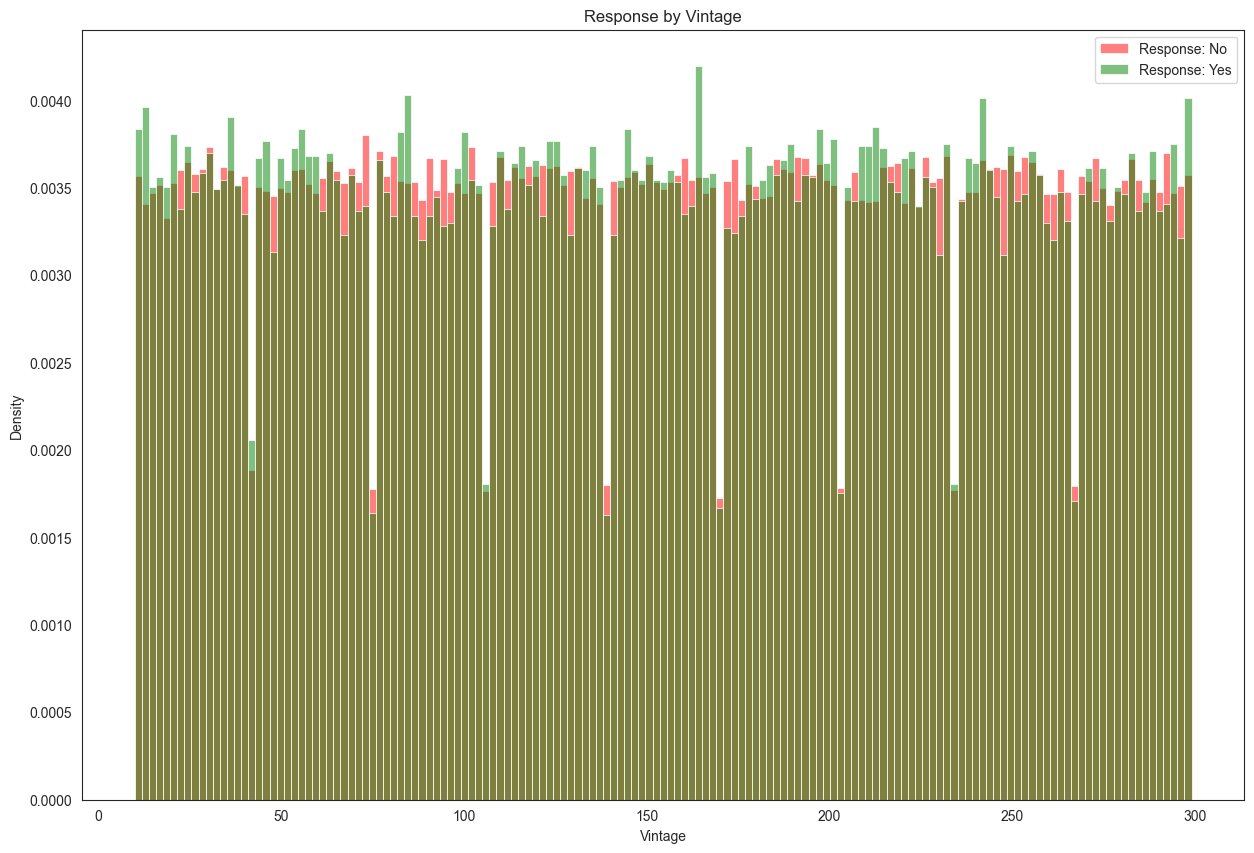

In [28]:
vintage_resp = df_train[["Vintage", "Response"]]

fig, ax = plt.subplots(figsize=(15, 10))
# Plot the histogram for Response 0
sns.histplot(vintage_resp[vintage_resp["Response"]==0]["Vintage"], ax=ax, stat='density',
             color='red', alpha=0.5, element='bars', fill=True, 
             bins=int(vintage_resp['Vintage'].max()/ 2)) # ,int(vintage_resp['Vintage'].max()/ 2)
# Plot the histogram for Response 1
sns.histplot(vintage_resp[vintage_resp["Response"]==1]["Vintage"], ax=ax, stat='density',
             color='green', alpha=0.5, element='bars', fill=True, 
             bins=int(vintage_resp['Vintage'].max()/ 2))

ax.set_xlabel('Vintage')
ax.set_ylabel('Density')
# ax.set_ylim(0.0025)
ax.set_title('Response by Vintage')
ax.legend(labels=['Response: No', 'Response: Yes'])
plt.show()

From the histogram above, it is possible to observe that there are **no clear differences** between the density in different seniority categories of the Health Insurance clients who are more inclined to acquire a Vehicle Insurance and those who aren't, regardless the slight dominance in "No" Responses.

In [29]:
## Could be interest to associate this with the Previously_Insured variable

#### Region vs Response

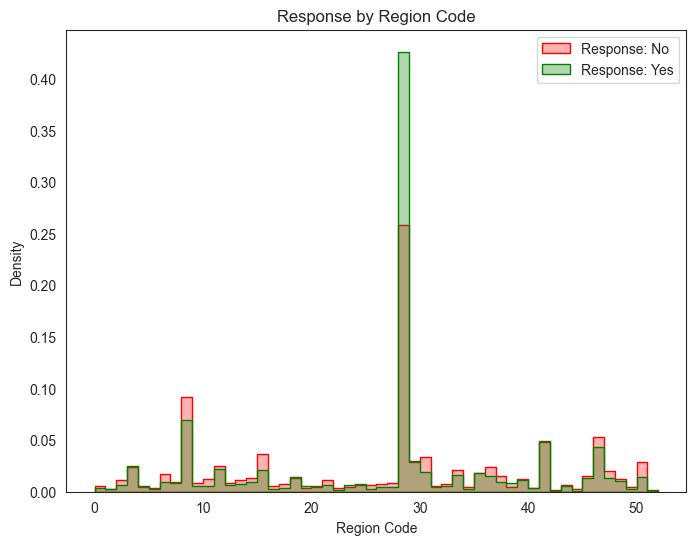

In [34]:
region_code_resp = df_train[["Region_Code", "Response"]]

fig, ax = plt.subplots(figsize=(8,6))
# Plot the density histogram for Response 0
sns.histplot(region_code_resp[region_code_resp["Response"]==0]["Region_Code"], ax=ax, 
             stat='density', color='red', alpha=0.3, element='step', fill=True, 
             bins=int(region_code_resp['Region_Code'].max()))
# Plot the density histogram for Response 1
sns.histplot(region_code_resp[region_code_resp["Response"]==1]["Region_Code"], ax=ax, 
             stat='density', color='green', alpha=0.3, element='step', fill=True, 
             bins=int(region_code_resp['Region_Code'].max()))

ax.set_xlabel("Region Code")
ax.set_ylabel("Density")
ax.set_title("Response by Region Code")
ax.legend(labels=["Response: No", "Response: Yes"])
plt.show()


In [48]:
int(region_code_resp["Region_Code"].value_counts().idxmax())

28

There is a clear **spike in Region Code 28, where the majority of the Responses is "Yes"**. This may represent a region where customers are much more likely to buy vehicle insurance.
<br><br>

The other Region Codes have a spread of "Yes" and "No" Responses and in significantly low densities. Overall, there are more "No" Responses than "Yes" Responses (due to the fact that most of our Responses are "No")
<br><br>

Regarding the spike in Region Code 28, this might occur because of this being **an area traditionally with more accidents than the others**, increasing the need for a Vehicle Insurance. Let's explore this below:

In [55]:
damage_regcode_resp = df_train[df_train["Response"]==1] \
                                        .groupby(["Vehicle_Damage", 
                                                  "Region_Code"])["Response"] \
                                                    .count() \
                                                        .to_frame() \
                                                            .reset_index() \
                                                            .rename(columns={'Response': 'count'})

damage_regcode_resp

,Vehicle_Damage,Region_Code,count
0,No,2.0,3
1,No,3.0,28
2,No,4.0,7
3,No,5.0,4
4,No,6.0,17
...,...,...,...
97,Yes,48.0,383
98,Yes,49.0,109
99,Yes,50.0,510
100,Yes,51.0,24


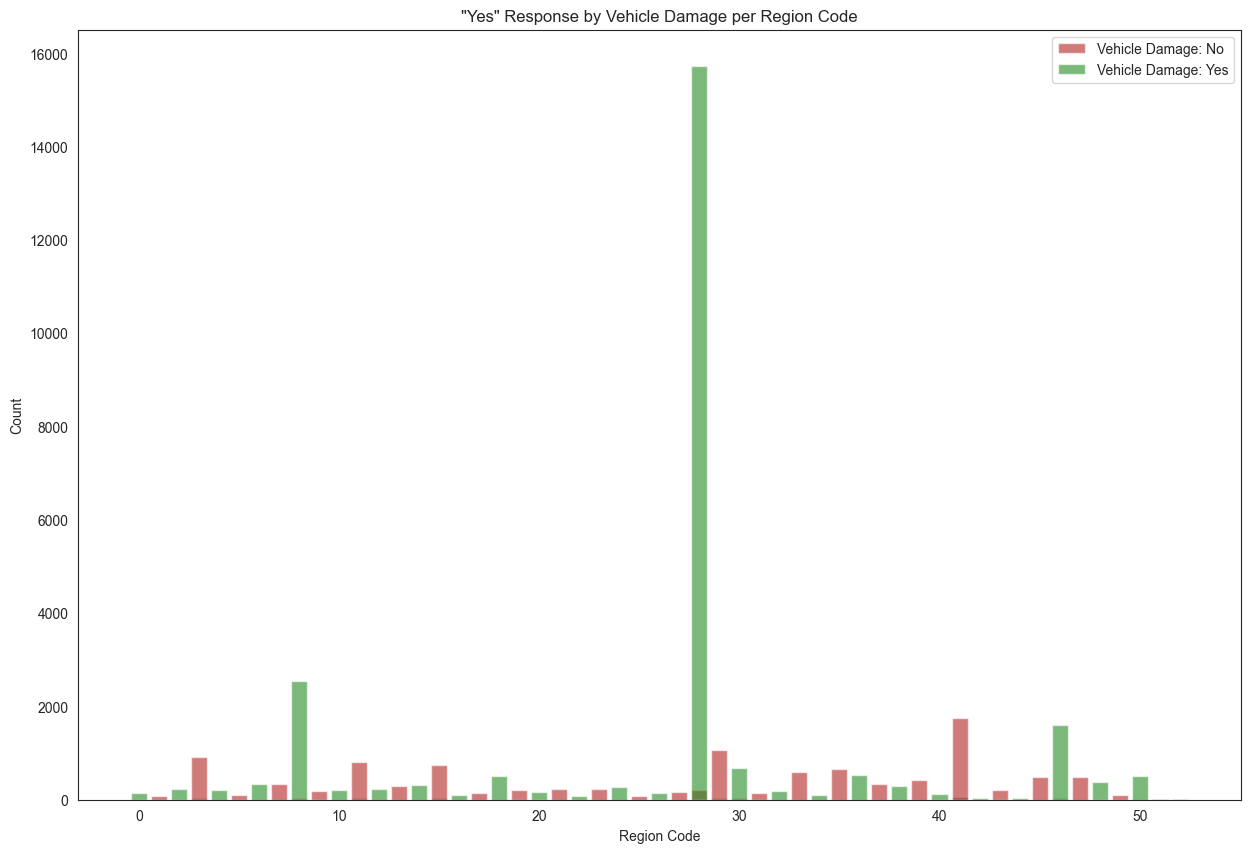

In [69]:
plt.figure(figsize=(15,10))
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.title('"Yes" Response by Vehicle Damage per Region Code')
bars = plt.bar(damage_regcode_resp['Region_Code'], damage_regcode_resp['count'], 
               color=['firebrick', 'forestgreen'], alpha=0.6)
plt.legend(bars, ['Vehicle Damage: No', 'Vehicle Damage: Yes'])
plt.show()

In [94]:
damage_regcode_resp = df_train.groupby(["Region_Code",
                                        "Response"])["Vehicle_Damage"] \
                                        .count().to_frame("count").reset_index()

damage_regcode_resp["Response"] = damage_regcode_resp["Response"].replace({0:"No", 1:"Yes"})
damage_regcode_resp

,Region_Code,Response,count
0,0.0,No,1482
1,0.0,Yes,141
2,1.0,No,711
3,1.0,Yes,85
4,2.0,No,2983
...,...,...,...
101,50.0,Yes,518
102,51.0,No,122
103,51.0,Yes,24
104,52.0,No,190


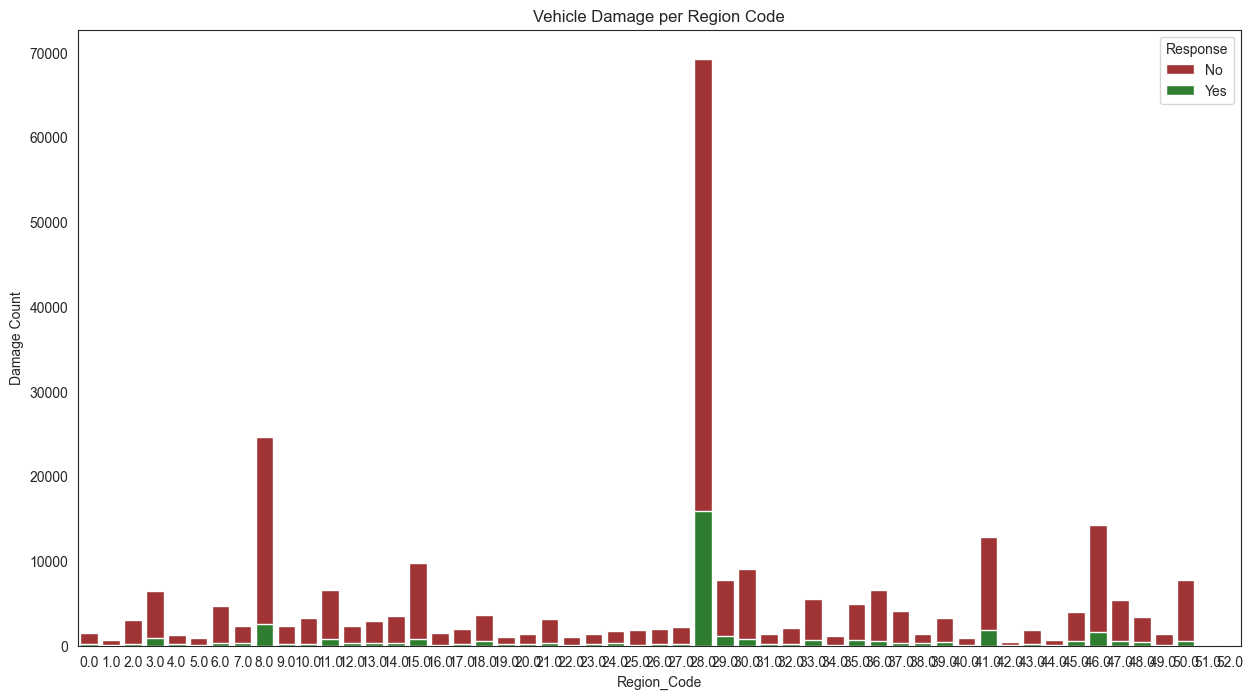

In [99]:
plt.figure(figsize=(15,8))
stack_bars = sns.barplot(x='Region_Code', y='count', hue='Response', 
                        data=damage_regcode_resp, palette=["firebrick", "forestgreen"],
                        dodge=False)
plt.ylabel('Damage Count')
plt.title('Vehicle Damage per Region Code')
plt.show()

#### Policy Sales Channel vs Response

#### Annual Premium vs Response

## **Feature Engineering**

## **Feature Selection**

## **Data Augmentation**

## **Modeling**